# evaluating the model against the full enformer task

In [ ]:
#we trained a model to do the full task of enformer. we can use the alst epoch since it consistentlly was going down

#so have to load in model and then evaluate by using a version of the model like eQTL
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '5'
import sys
sys.path.append('/data1/lesliec/sarthak/caduceus/')
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import argparse
from src.dataloaders.datasets.general_dataset import GeneralDataset
from src.models.sequence.dna_embedding import DNAEmbeddingModelCaduceus
from src.tasks.decoders import EnformerDecoder
from src.tasks.encoders import JointCNN
from caduceus.configuration_caduceus import CaduceusConfig
import yaml
from omegaconf import OmegaConf
import os
import itertools
import inspect
import zarr
from numcodecs import Blosc
from scipy.stats import spearmanr, pearsonr
from torch.utils.data import DataLoader
import pickle

try:
    OmegaConf.register_new_resolver('eval', eval)
    OmegaConf.register_new_resolver('div_up', lambda x, y: (x + y - 1) // y)
except ValueError as e:
    if "Resolver already registered" in str(e):
            print("Resolver already exists, skipping registration.")

class Evals():
    def __init__(self,
                 ckpt_path,
                 dataset=None,
                 split = 'test',
                 device = None,
                 load_data=False,
                 **dataset_overrides #Don't pass None into overrides unless you intentionally want it to be None! Pass in items only that you need
                 ) -> None:
        
        #now load the cfg from the checkpoint path
        model_cfg_path = os.path.join(os.path.dirname(os.path.dirname(ckpt_path)), '.hydra', 'config.yaml')
        cfg = yaml.load(open(model_cfg_path, 'r'), Loader=yaml.FullLoader)
        cfg = OmegaConf.create(cfg)
        self.cfg = OmegaConf.to_container(cfg, resolve=True)
        
        state_dict = torch.load(ckpt_path, map_location='cpu')
        if device is not None:
            #if we are given a device, we will use that device
            self.device = torch.device(device)
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.split = split

        #now set up dataset
        if dataset is None:
            dataset_args = self.cfg['dataset']
            # assert dataset_args['mlm'] == 0 and dataset_args['acc_mlm'] == 0, "MLM and acc_mlm should be 0 for the training"
            sig = inspect.signature(GeneralDataset.__init__)
            sig = {k: v for k, v in sig.parameters.items() if k != 'self'}
            to_remove = []
            for k, v in dataset_args.items():
                if k not in sig:
                    # del dataset_args[k]
                    to_remove.append(k)
            for k in to_remove:
                del dataset_args[k]
            dataset_args['split'] = split
            dataset_args['evaluating'] = True #this tells it to not do things like random shifting and rc aug, still does random masking tho, can get og sequence easily
            dataset_args['load_in'] = load_data
            
            for k, v in dataset_overrides.items():
                if k in sig:
                    dataset_args[k] = v
                    print(f"Overriding {k} with {v}")
                else:
                    print(f"Warning: {k} not in dataset args, skipping")
            
            # dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset_args = dataset_args
            # self.dataset_args['rc_aug'] = False #we don't want to do rc aug in our evaluation class!!!
            self.dataset = GeneralDataset(**dataset_args)
            
            # self.kmer_len = dataset_args['kmer_len']
            # self.dataset = enformer_dataset.EnformerDataset(split, dataset_args['max_length'], rc_aug = dataset_args['rc_aug'],
            #                                                 return_CAGE=dataset_args['return_CAGE'], cell_type=dataset_args.get('cell_type', None),
            #                                                 kmer_len=dataset_args['kmer_len']) #could use dataloader instead, but again kinda complex
        else:
            self.dataset = dataset
         
        torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            state_dict["state_dict"], "model."
        )
        model_state_dict = state_dict["state_dict"]
        # need to remove torchmetrics. to remove keys, need to convert to list first
        for key in list(model_state_dict.keys()):
            if "torchmetrics" in key:
                model_state_dict.pop(key)
        # the state_dict keys slightly mismatch from Lightning..., so we fix it here
        decoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "decoder" in key:
                decoder_state_dict[key[10:]] = model_state_dict.pop(key)
        encoder_state_dict = {}
        for key in list(model_state_dict.keys()):
            if "encoder" in key:
                encoder_state_dict[key[10:]] = model_state_dict.pop(key)
        
        cfg['model']['config'].pop('_target_')
        # cfg['model']['config']['complement_map'] = self.dataset.tokenizer.complement_map
        caduceus_cfg = CaduceusConfig(**cfg['model']['config'])
        
        self.backbone = DNAEmbeddingModelCaduceus(config=caduceus_cfg)
        self.backbone.load_state_dict(model_state_dict, strict=True)
        
        #remove self.cfg['decoder']['_name_']
        del self.cfg['decoder']['_name_']
        self.cfg['decoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.decoder = EnformerDecoder(**self.cfg['decoder']) #could do with instantiating, but that is rather complex
        self.decoder.load_state_dict(decoder_state_dict, strict=True)
        
        del self.cfg['encoder']['_name_']
        self.cfg['encoder']['d_model'] = self.cfg['model']['config']['d_model']
        self.encoder = JointCNN(**self.cfg['encoder'])
        self.encoder.load_state_dict(encoder_state_dict, strict=True)
        
        self.encoder.to(self.device).eval()
        self.backbone.to(self.device).eval()
        self.decoder.to(self.device).eval()
        
    def __call__(self, idx=None, data=None):
        #now evaluate the model on one example
        if data is None:
            (seq,acc),(seq_unmask,acc_unmask, exp) = self.dataset[idx]
            
            x = seq.unsqueeze(0)
            y = acc.unsqueeze(0)
        else:
            (x,y),(seq_unmask,acc_unmask, exp) = data

            if x.dim() == 2:
                x = x.unsqueeze(0) #add batch dim
                y = y.unsqueeze(0) #add batch dim
        
        x,y = x.to(self.device), y.to(self.device)
        
        with torch.no_grad():
            x1 = self.encoder(x,y)
            x1,_ = self.backbone(x1)
            x1 = self.decoder(x1)
        
        return x1

In [5]:
ckpt_path = '/data1/lesliec/sarthak/caduceus/outputs/2025-06-16/15-19-36-043179/checkpoints/73-val_loss=0.51087.ckpt'
evals = Evals(ckpt_path,load_data=False)

JointMaskingEncoder: d_model=256, d_input1=6, d_input2=2, joint=False, kernel_size=15, combine=True, acc_type=continuous


In [8]:
(seq,acc),(seq_unmask,acc_unmask,exp) = evals.dataset[0]
x = seq.unsqueeze(0)
y = acc.unsqueeze(0)

x1 = evals.encoder(x,y)
x1.shape

torch.Size([1, 256, 524288])

In [10]:
#can't run it through mamba, just want to get shapes, let's run through decoder
x2 = evals.decoder(x1.transpose(1,2))  # Transpose to match expected input shape for decoder
x2.shape

torch.Size([1, 896, 5313])

In [15]:
#that looks exactly right, and then we can save it out for the test set!!

x2.nbytes*2000/1e9 #30GB is reasonable, this will be temporary

38.083584

In [13]:
exp.shape

(896, 5313)

In [14]:
len(evals.dataset)

1937

In [18]:
exp

array([[0.04208374, 0.04983521, 0.01158905, ..., 0.        , 0.        ,
        0.        ],
       [0.05300903, 0.04168701, 0.04956055, ..., 0.        , 0.        ,
        0.        ],
       [0.05258179, 0.0109787 , 0.01287842, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.09313965, 0.15600586, 0.32202148, ..., 0.        , 0.        ,
        0.        ],
       [0.07489014, 0.08380127, 0.23303223, ..., 0.        , 0.        ,
        0.        ],
       [0.11328125, 0.13024902, 0.16992188, ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

# now actually do it

In [2]:
#let's ensure that our outputs targets are the same
import numpy as np
a = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/evals_mamba_fullenformer.npz')
a.keys()

KeysView(NpzFile '/data1/lesliec/sarthak/data/joint_playground/model_out/evals_mamba_fullenformer.npz' with keys: true_out, pred_out)

In [4]:
targets = a['true_out']
targets.shape

(1937, 896, 5313)

In [5]:
preds = a['pred_out']
preds.shape

(1937, 896, 5313)

In [6]:
#let's make sure the targets are the same as the true ones

t1 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/GM12878_base_targets_conv.npy')
t2 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/nobcell_CAGE_targets.npy')[:,:,0]
t3 = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/immune_CAGE_targets.npy')[:,:,0]
t1.shape, t2.shape, t3.shape

((1937, 896), (1937, 896), (1937, 896))

In [8]:
print(np.allclose(t1, t2))
print(np.allclose(t1, t3))
# print(np.allclose(t1,targets))

True
True


In [ ]:
print(np.allclose(t1,targets[:,:,5110])) #ok perfect, it does indeed match! Now we have to correlate!

True


In [ ]:
#so doing this correlation is actually not that easy! Let's look at our old code for the pearsonr2

def pearsonr2(x, y):
    # Compute Pearson correlation coefficient. We can't use `cov` or `corrcoef`
    # because they want to compute everything pairwise between rows of a
    # stacked x and y.
    xm = x.mean(axis=-1, keepdims=True)
    ym = y.mean(axis=-1, keepdims=True)
    cov = np.sum((x - xm) * (y - ym), axis=-1)/(x.shape[-1]-1)
    sx = np.std(x, ddof=1, axis=-1)
    sy = np.std(y, ddof=1, axis=-1)
    rho = cov/(sx * sy)
    return rho

#first reshape the targets and preds to be (1937, 5313, 896)
temptargets = np.moveaxis(targets,1,-1)
temppreds = np.moveaxis(preds,1,-1)
temptargets.shape, temppreds.shape

NameError: name 'targets' is not defined

In [ ]:
#now run pearsonr2  on it
pearson_r = pearsonr2(temptargets, temppreds)
pearson_r.shape

In [ ]:
#let's verify that this is correct by checking some random correlation
from scipy.stats import pearsonr
#so let's try getting pearon_r[0,0]
pearsonr(targets[0,:,0], preds[0,:,0]), pearson_r[0,0] #they do indeed match, let's choose a random i and j value

In [ ]:
pearsonr(targets[30,:,133], preds[30,:,133]), pearson_r[30,133] #they do indeed match!!

# now doing a plot

In [ ]:
#did all this in the terminal and saved it out
import numpy as np
pearson_r = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/evals_mamba_fullenformer_corr.npy')
pearson_r.shape

(1937, 5313)

In [5]:
#let's also get the enformer correlations
enformer_corr = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy_corrsfull.npy')
enformer_corr.shape

(1937, 5313)

In [ ]:
enformer_corr.mean(0) #hmm pretty high

array([0.757189  , 0.79036826, 0.64110535, ..., 0.34588456, 0.38112652,
       0.409334  ], dtype=float32)

In [ ]:
pearson_r.mean(0) #some are for some reason way higher... wtf?

array([0.70746497, 0.73825148, 0.59046556, ..., 0.31991583, 0.42488884,
       0.42856644])

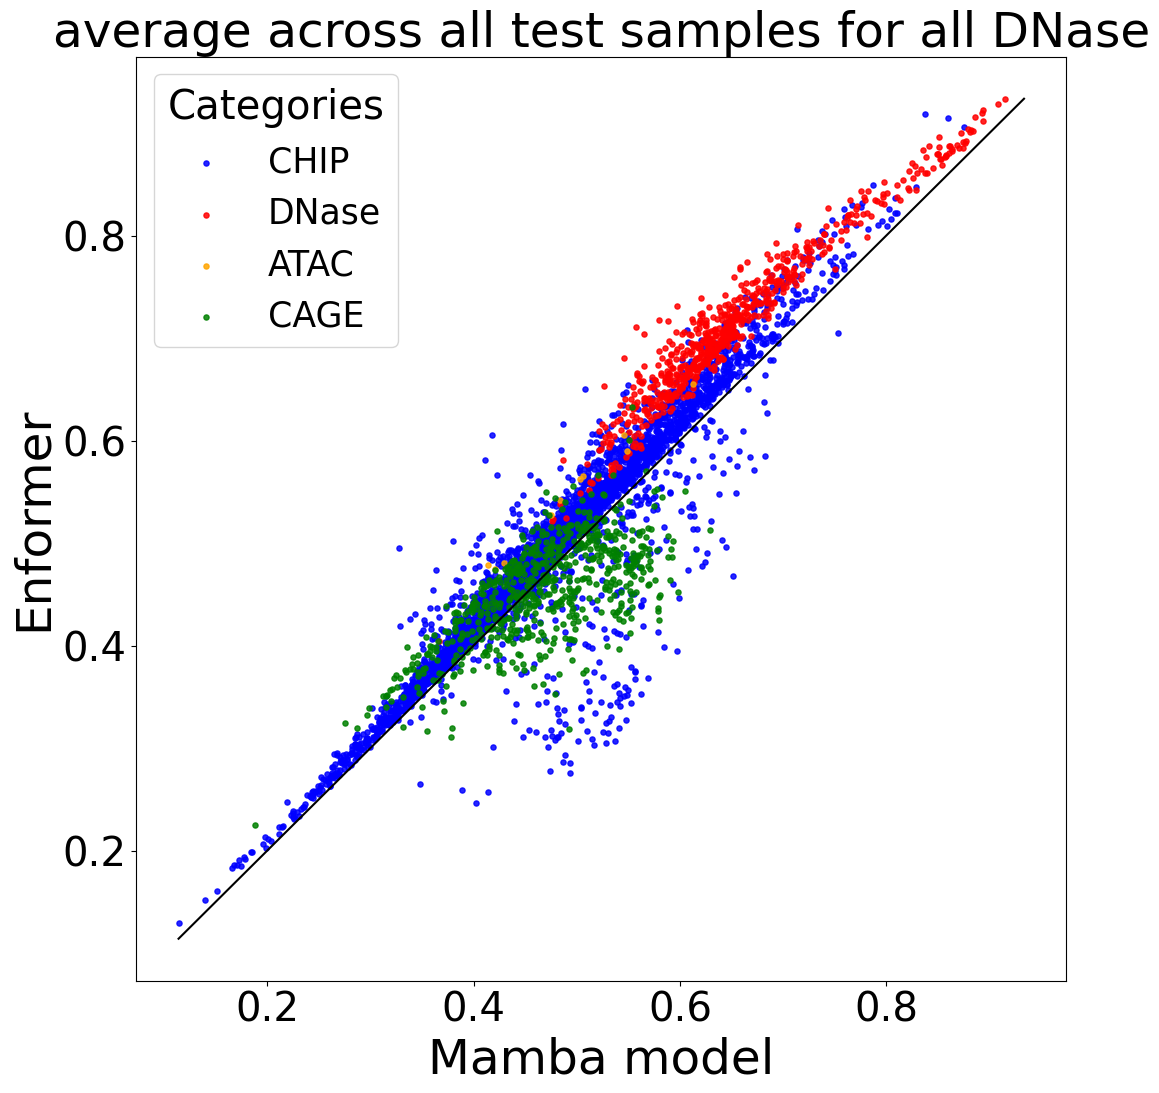

In [11]:
#now we'll do a plot where we compare
import matplotlib.pyplot as plt
def fixcorrs(corr):
    corr[np.isnan(corr)] = 0
    corr[corr == -np.inf] = 0
    return corr

y,x = fixcorrs(enformer_corr).mean(0), fixcorrs(pearson_r).mean(0)

z2 = np.zeros_like(x)
z2[:675] = 1  # DNase (Category 0)
z2[675:685] = 2  # ATAC (Category 1)
z2[685:4675] = 0  # CHIP (Category 2)
z2[4675:] = 3  # CAGE (Category 3)

# Define the colors for each category
colors = ['blue', 'red', 'orange', 'green']

# Create a color array based on z2
color_labels = np.array([colors[int(label)] for label in z2])

# Create a scatter plot with different colors for each category
plt.figure(1, figsize=(12, 12)).clf()

for i, color in enumerate(colors):
    plt.scatter(x[z2 == i], y[z2 == i], color=color, label=['CHIP', 'DNase', 'ATAC', 'CAGE'][i], s=55, marker='.', alpha=0.85)

tempmin = np.min([np.min(x), np.min(y)])
tempmax = np.max([np.max(x), np.max(y)])

# plt.figure(1,figsize=(12,12)).clf()
# s = plt.scatter(x, y, c=z2, cmap='jet', marker='.', s = 85)
plt.plot([tempmin, tempmax], [tempmin, tempmax], c='k')  

plt.xlabel('Mamba model', fontsize=35)
plt.ylabel('Enformer', fontsize=35)
plt.title('average across all test samples for all DNase', fontsize=35)
plt.tick_params(labelsize=29)
plt.legend(title="Categories", fontsize=25, title_fontsize=29)

In [16]:
#this is really strange. Let's find one of the examples where it is much better and manually verify this!
diff = pearson_r.mean(0) - enformer_corr.mean(0)
print(np.where(diff > 0.1)) #find the indices where the difference is greater
diff

(array([ 717,  791,  832, 1102, 1104, 1109, 1111, 1113, 1115, 1117, 1118,
       1122, 1126, 1128, 1129, 1132, 1143, 1154, 1156, 1160, 1161, 1164,
       1165, 1167, 1169, 1171, 1173, 1175, 1176, 1182, 1184, 1185, 1187,
       1189, 1192, 1194, 1196, 1199, 1202, 1207, 1208, 1210, 1212, 1214,
       1218, 1220, 1221, 1224, 1225, 1227, 1229, 1231, 1234, 1235, 1236,
       1238, 1239, 1387, 1406, 1441, 1463, 1560, 1679, 1692, 1835, 1859,
       1866, 1877, 1988, 2009, 2049, 2066, 2084, 2266, 2360, 2409, 2535,
       2654, 2734, 2737, 2778, 2783, 2791, 2928, 2960, 3028, 3086, 3095,
       3226, 3239, 3325, 3328, 3620, 3660, 3734, 3864, 3915, 3916, 3954,
       3964, 4080, 4172, 4207, 4296, 4386, 4391, 4701, 4702, 4703, 4705,
       4706, 4707, 4708, 4711, 4713, 4764, 4765, 4769, 4771, 4774, 4776,
       4777, 4787, 4804, 4811, 4812, 4822, 4872, 4907, 4908, 5108, 5109,
       5110, 5118, 5123, 5144, 5211, 5212, 5216, 5217, 5255, 5274, 5276,
       5295]),)


array([-0.04972401, -0.05211678, -0.05063979, ..., -0.02596873,
        0.04376231,  0.01923243])

In [ ]:
pearson_r.mean(0)[5110], enformer_corr.mean(0)[5110] #this is one that is much higher, this is strange and it's GM121878 expression correlation

(0.5799733554445019, 0.42488012)

In [ ]:
#first I manuallyy verified that this is indeed the case by calculating pearson correlation with the outputs
tempout = []
for i in range(1937):
    tempout.append(pearsonr(targets[i,:,5110], preds[i,:,5110])[0])

In [ ]:
#it is legitimately absurdly high when we manually did that!

In [ ]:
#and I think enformer is legit that low, so we just have a large increase for some reason!
#let's manually look at outputs of these models then?
#saved out targets and the predictions so we cna load it in here and it not take 15 minutes

# manuallyl looking at examples

In [18]:
a = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/evals_mamba_fullenformer.npz')
targets = a['true_out']
preds = a['pred_out']
targets.shape, preds.shape

((1937, 896, 5313), (1937, 896, 5313))

In [19]:
enformer = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy')

In [20]:
enformer.shape

(1937, 896, 5313)

In [35]:
#now let's look at some of the output tracks
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

file_path = '/data1/lesliec/sarthak/data/DK_zarr/targets_enformer.txt'

# Initialize an empty dictionary
targets_dict = {}

# Open and read the file
with open(file_path, 'r') as file:
    for line in file:
        #skip the first line
        if line.startswith('index'):
            continue
        # Split the line into columns
        columns = line.strip().split('\t')
        
        # The first column (index 0) is the key
        key = int(columns[0])
        
        # The last column is the description
        description = columns[-1]
        
        # Add to the dictionary
        targets_dict[key] = description

def plot_track(model_out, enf_out, targets, idx, track=121):
    '''
    Given an index, plots one track and compares it to the real results for multiple evaluation classes
    '''
    
    
    fig, axes = plt.subplots(3, 1, figsize=(8, 4 * 1.5), sharex=True)
    
    custom_palette = sns.color_palette("deep", n_colors=3)
    
    ymax = np.max([np.max(model_out[idx,:,track]), np.max(enf_out[idx,:,track]), np.max(targets[idx, :, track])]) *1.05
    ymin = -0.1

    axes[0].plot(model_out[idx,:,track], label='Mamba Model Output', color='b')
    corr = pearsonr(targets[idx, :, track], model_out[idx,:,track])[0]
    axes[0].set_title(f'Mamba Model Output, Pearson r: {corr:.3f}')
    axes[0].legend()
    axes[0].set_ylim(ymin, ymax)

    axes[-2].plot(enf_out[idx,:,track], label='Enformer Output', color='g')
    corr_enf = pearsonr(targets[idx, :, track], enf_out[idx,:,track])[0]
    axes[-2].set_title(f'Enformer Output, Pearson r: {corr_enf:.3f}')
    axes[-2].legend()
    axes[-2].set_ylim(ymin, ymax)

    axes[-1].plot(targets[idx, :, track], label='Actual Coverage', color='r')
    axes[-1].set_title('Actual Coverage')
    axes[-1].legend()
    axes[-1].set_ylim(ymin, ymax)

    axes[-1].set_xlabel('Position')
    fig.suptitle(f'Model Coverage Comparison, Track {targets_dict[track]}, sample {idx}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return fig, axes

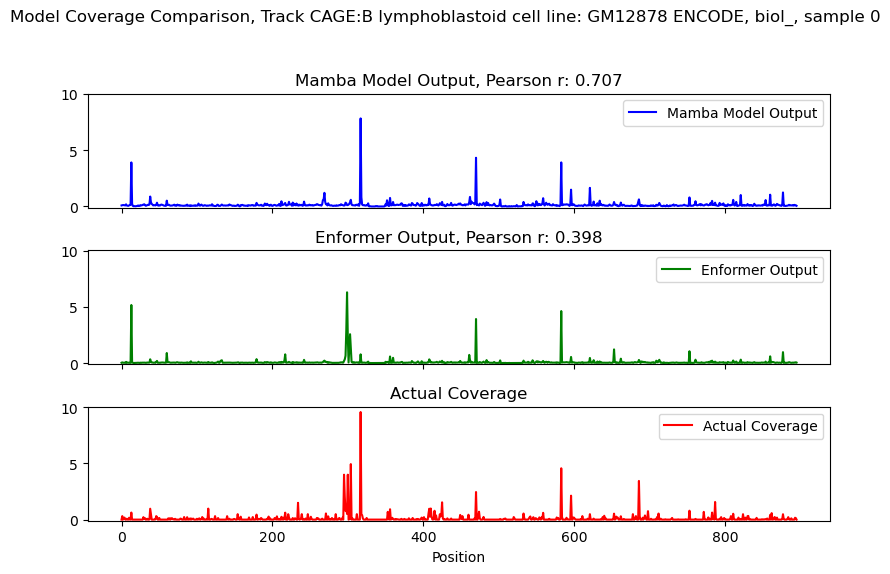

(<Figure size 800x600 with 3 Axes>,
 array([<Axes: title={'center': 'Mamba Model Output, Pearson r: 0.707'}>,
        <Axes: title={'center': 'Enformer Output, Pearson r: 0.398'}>,
        <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>],
       dtype=object))

In [36]:
plot_track(preds, enformer, targets, 0, track=5110)

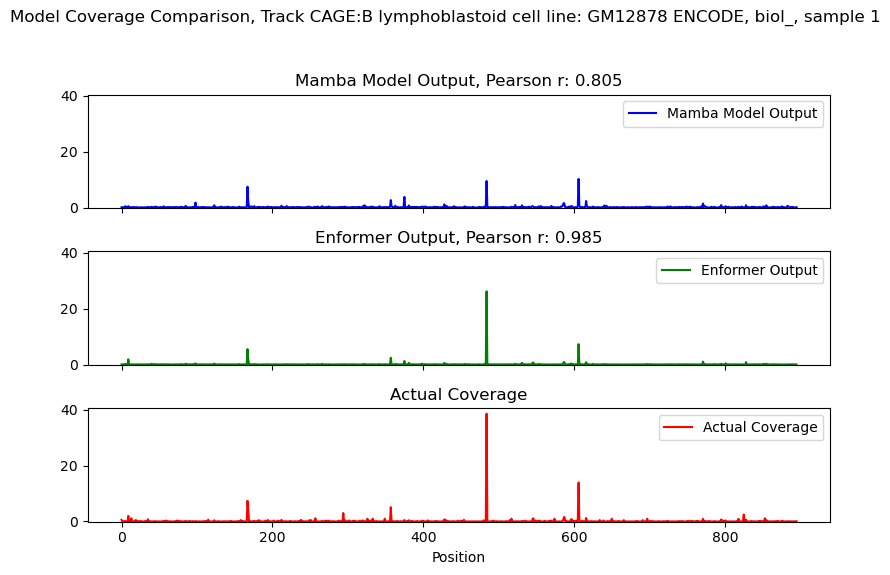

(<Figure size 800x600 with 3 Axes>,
 array([<Axes: title={'center': 'Mamba Model Output, Pearson r: 0.805'}>,
        <Axes: title={'center': 'Enformer Output, Pearson r: 0.985'}>,
        <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>],
       dtype=object))

In [37]:
plot_track(preds, enformer, targets, 1, track=5110)

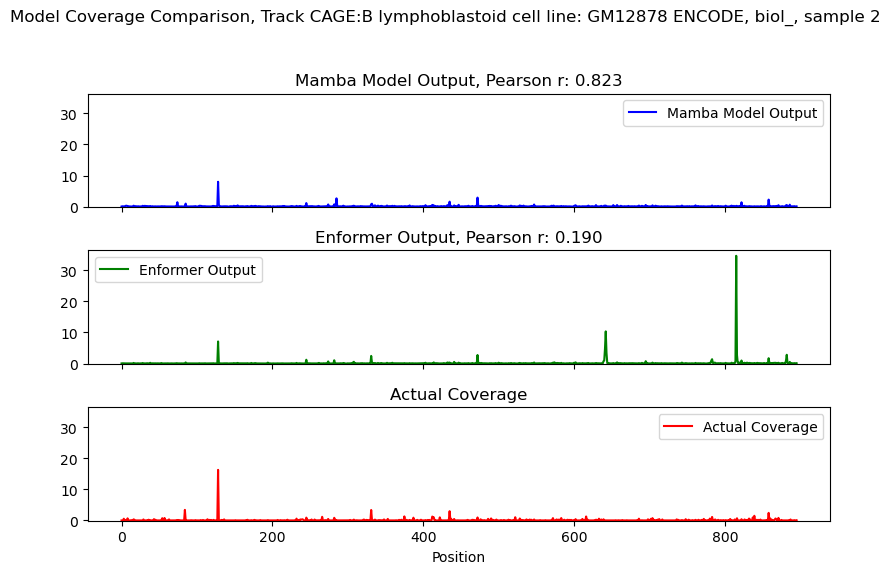

(<Figure size 800x600 with 3 Axes>,
 array([<Axes: title={'center': 'Mamba Model Output, Pearson r: 0.823'}>,
        <Axes: title={'center': 'Enformer Output, Pearson r: 0.190'}>,
        <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>],
       dtype=object))

In [38]:
#let's keep looking
plot_track(preds, enformer, targets, 2, track=5110)

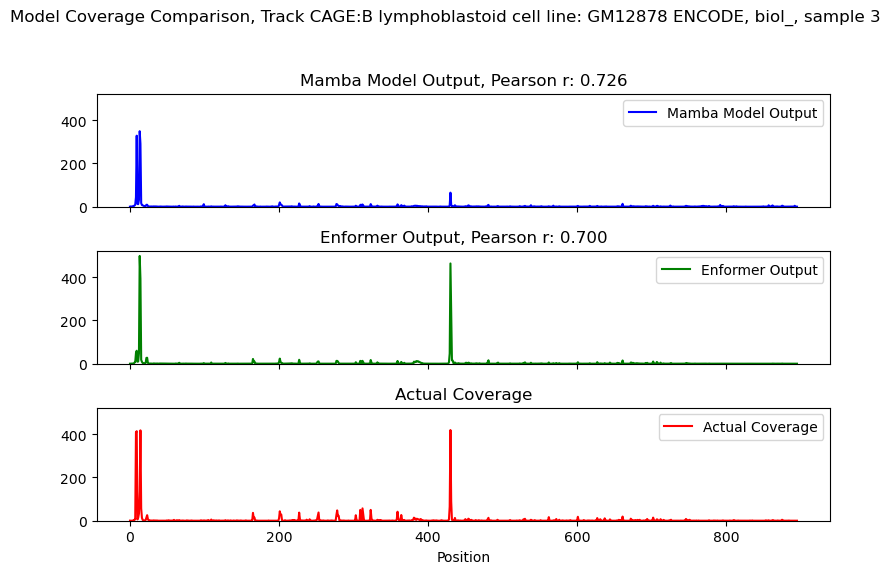

(<Figure size 800x600 with 3 Axes>,
 array([<Axes: title={'center': 'Mamba Model Output, Pearson r: 0.726'}>,
        <Axes: title={'center': 'Enformer Output, Pearson r: 0.700'}>,
        <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>],
       dtype=object))

In [40]:
plot_track(preds, enformer, targets, 3, track=5110)

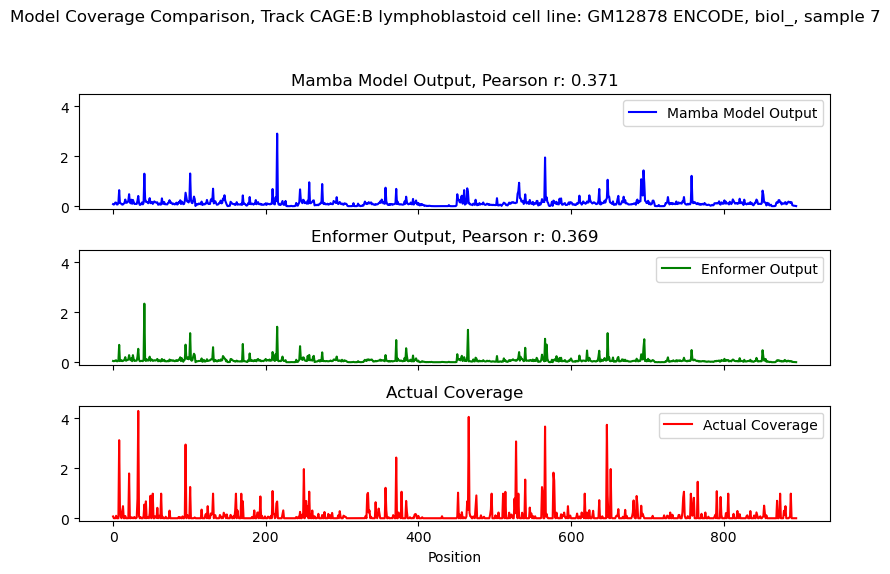

(<Figure size 800x600 with 3 Axes>,
 array([<Axes: title={'center': 'Mamba Model Output, Pearson r: 0.371'}>,
        <Axes: title={'center': 'Enformer Output, Pearson r: 0.369'}>,
        <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>],
       dtype=object))

In [43]:
plot_track(preds, enformer, targets, 7, track=5110)

# for the 5110 track, look at violin plot

In [44]:
#we can now look specifically at the corrs
enformer_corr = np.load('/data1/lesliec/sarthak/data/enformer/data/model_out/enformer.npy_corrsfull.npy')
mamba_corr = np.load('/data1/lesliec/sarthak/data/joint_playground/model_out/evals_mamba_fullenformer_corr.npy')
enformer_corr.shape, mamba_corr.shape

((1937, 5313), (1937, 5313))

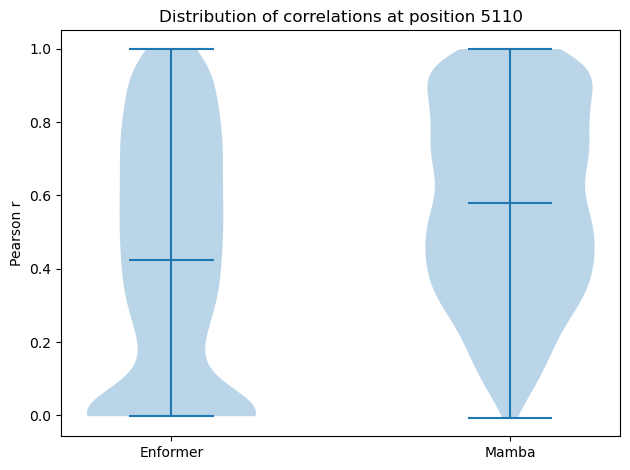

In [45]:
#now let's look at track 5110 and look at a violin plot
import seaborn as sns
import matplotlib.pyplot as plt


# your two vectors
data = [
    enformer_corr[:, 5110],
    mamba_corr[:,   5110]
]

fig, ax = plt.subplots()
ax.violinplot(data, showmeans=True, showextrema=True)

# label the violins
ax.set_xticks([1, 2])
ax.set_xticklabels(['Enformer', 'Mamba'])

ax.set_ylabel('Pearson r')
ax.set_title('Distribution of correlations at position 5110')

plt.tight_layout()
plt.show()


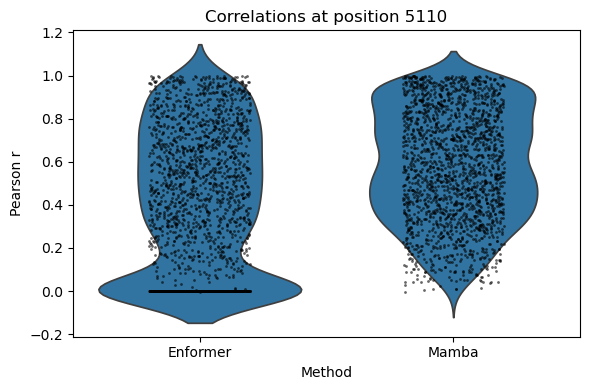

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# assume these are your two 1D arrays
enf = enformer_corr[:, 5110]
mmb = mamba_corr[:,   5110]

# build a long-form DataFrame
df = pd.DataFrame({
    'Correlation': np.concatenate([enf, mmb]),
    'Method':      ['Enformer']*len(enf) + ['Mamba']*len(mmb)
})

plt.figure(figsize=(6, 4))
# draw the violins without inner markings
sns.violinplot(x='Method', y='Correlation', data=df, inner=None)
# overlay individual points
sns.stripplot(x='Method', y='Correlation', data=df,
              color='k', size=2, jitter=0.2, alpha=0.6)

plt.title('Correlations at position 5110')
plt.ylabel('Pearson r')
plt.tight_layout()
plt.show()


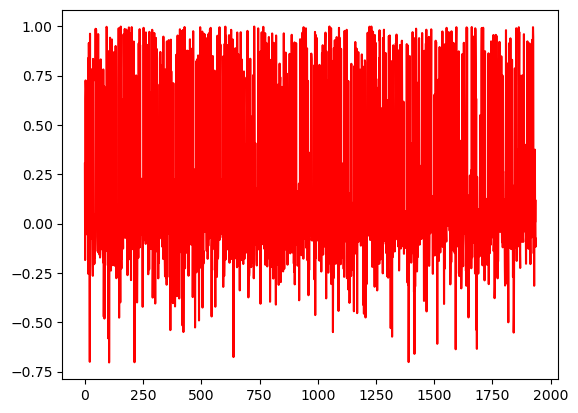

In [ ]:
# plt.plot(mamba_corr[:, 5110], label='Mamba Model', color='b')
# plt.plot(enformer_corr[:, 5110], label='Enformer', color='g')
plt.plot(mamba_corr[:,5110] - enformer_corr[:,5110], label='Difference', color='r') #some examples where it's almost 1?

In [55]:
diff = mamba_corr[:,5110] - enformer_corr[:,5110]
#find max values of diff and indices
print(np.max(diff), np.where(diff == np.max(diff))) #find the index where the max value is

0.9989906928428046 (array([1050]),)


In [57]:
mamba_corr[1050, 5110], enformer_corr[1050, 5110] #this is the one that is the most different, let's look at it

(0.9989906928428046, 0.0)

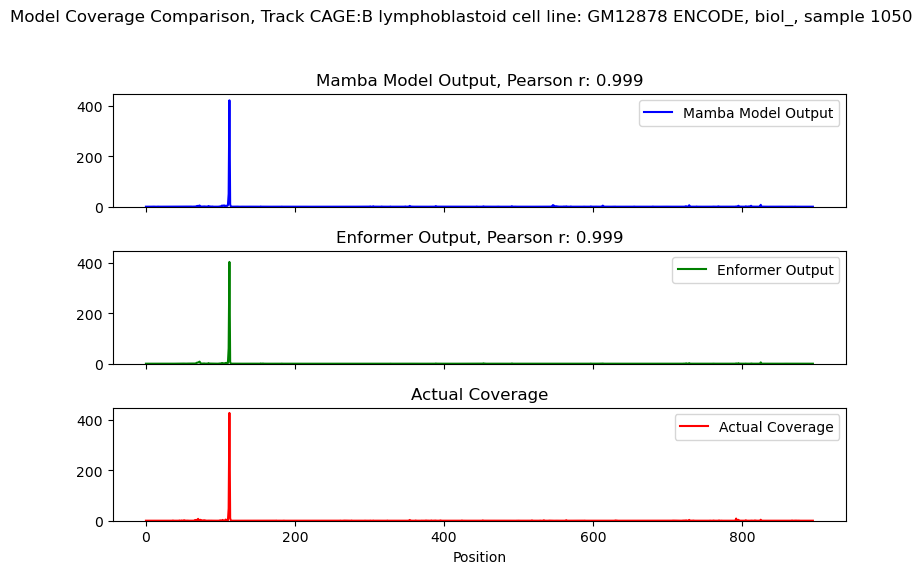

(<Figure size 800x600 with 3 Axes>,
 array([<Axes: title={'center': 'Mamba Model Output, Pearson r: 0.999'}>,
        <Axes: title={'center': 'Enformer Output, Pearson r: 0.999'}>,
        <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>],
       dtype=object))

In [56]:
plot_track(preds, enformer, targets, 1050, track=5110)

In [ ]:
#that's really strange, why is enformer set to 0?? It's such an easy prediction!

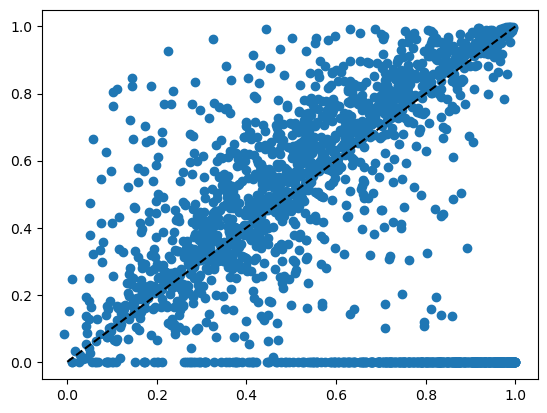

In [ ]:
#let's do a scatter plot
plt.scatter(mamba_corr[:, 5110], enformer_corr[:, 5110])
#and the y=x line
plt.plot([0, 1], [0, 1], c='k', linestyle='--') #yeah it's the 0s that are heavily biasing it. Let's run my correlation pearson r2 thing so we can properly save enformer correlations...

In [61]:
enformer.shape

(1937, 896, 5313)

In [62]:
targets.shape

(1937, 896, 5313)

In [63]:
temptargets = np.moveaxis(targets,1,-1)
tempenformer = np.moveaxis(enformer,1,-1)
temptargets.shape, tempenformer.shape

((1937, 5313, 896), (1937, 5313, 896))

In [68]:
enformer_corr = pearsonr2(tempenformer, temptargets)

/tmp/ipykernel_434053/4219113144.py:12: RuntimeWarning: invalid value encountered in divide
  rho = cov/(sx * sy)


In [69]:
np.save('/data1/lesliec/sarthak/data/joint_playground/model_out/enformer_corrs.npy', enformer_corr)

In [70]:
enformer_corr.shape

(1937, 5313)

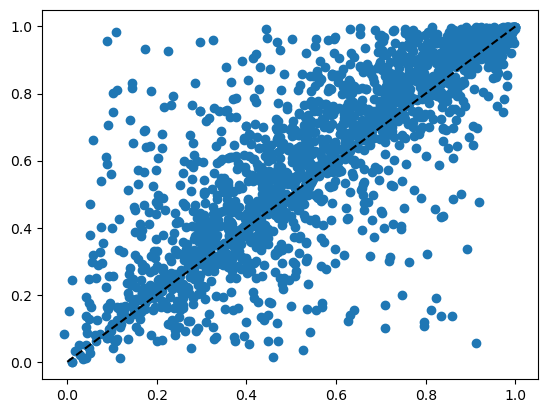

In [72]:
plt.scatter(mamba_corr[:, 5110], enformer_corr[:, 5110])
plt.plot([0, 1], [0, 1], c='k', linestyle='--') #now it looks much better, let's save this out

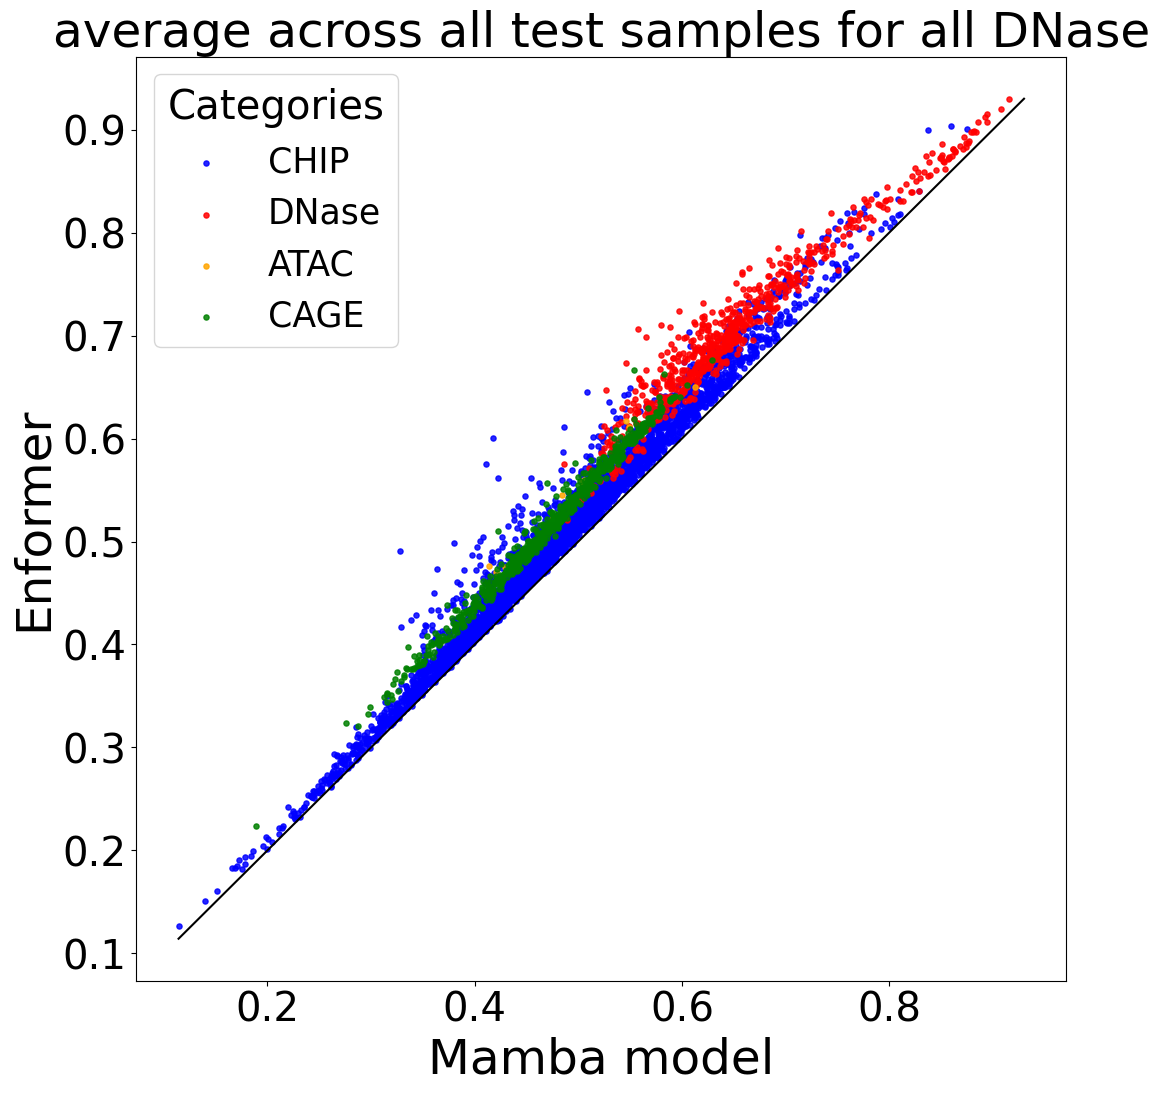

In [73]:
#ok now it's much more reasonable, let's redo the plot

import matplotlib.pyplot as plt
def fixcorrs(corr):
    corr[np.isnan(corr)] = 0
    corr[corr == -np.inf] = 0
    return corr

y,x = fixcorrs(enformer_corr).mean(0), fixcorrs(mamba_corr).mean(0)

z2 = np.zeros_like(x)
z2[:675] = 1  # DNase (Category 0)
z2[675:685] = 2  # ATAC (Category 1)
z2[685:4675] = 0  # CHIP (Category 2)
z2[4675:] = 3  # CAGE (Category 3)

# Define the colors for each category
colors = ['blue', 'red', 'orange', 'green']

# Create a color array based on z2
color_labels = np.array([colors[int(label)] for label in z2])

# Create a scatter plot with different colors for each category
plt.figure(1, figsize=(12, 12)).clf()

for i, color in enumerate(colors):
    plt.scatter(x[z2 == i], y[z2 == i], color=color, label=['CHIP', 'DNase', 'ATAC', 'CAGE'][i], s=55, marker='.', alpha=0.85)

tempmin = np.min([np.min(x), np.min(y)])
tempmax = np.max([np.max(x), np.max(y)])

# plt.figure(1,figsize=(12,12)).clf()
# s = plt.scatter(x, y, c=z2, cmap='jet', marker='.', s = 85)
plt.plot([tempmin, tempmax], [tempmin, tempmax], c='k')  

plt.xlabel('Mamba model', fontsize=35)
plt.ylabel('Enformer', fontsize=35)
plt.title('average across all test samples for all DNase', fontsize=35)
plt.tick_params(labelsize=29)
plt.legend(title="Categories", fontsize=25, title_fontsize=29)